# GPT-5-Mini MalayMMLU Evaluation Notebook

This notebook provides a comprehensive evaluation framework for testing GPT-5-mini on the MalayMMLU benchmark.

## Features:
- Flexible dataset size for testing (sample or full dataset)
- Support for 0-shot, 1-shot, 2-shot, and 3-shot evaluation
- Proper handling of GPT-5-mini specific parameters
- Category-wise and overall accuracy calculation
- Comparison with existing model benchmarks

## GPT-5-Mini Specifications:
- No `temperature` parameter support
- Uses `max_completion_tokens` instead of `max_tokens`

## 1. Setup and Configuration

In [21]:
# Install required packages
!pip install openai pandas numpy matplotlib seaborn python-dotenv

In [22]:
import pandas as pd
import numpy as np
import json
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
from dotenv import load_dotenv
import random
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

## 2. Configuration Parameters

In [23]:
# Configuration
class Config:
    # Model settings - GPT-5-mini is available
    MODEL_NAME = "gpt-5-mini"  # Now available!
    API_KEY = os.getenv("OPENAI_API_KEY")
    
    # Evaluation settings
    SHOT_OPTIONS = [0, 1, 2, 3]  # Available shot configurations
    SELECTED_SHOT = 0  # Change this to test different shot configurations
    
    # Dataset settings
    USE_SAMPLE = False  # 🔥 CHANGED: Set to False for FULL dataset evaluation
    SAMPLE_SIZE = None  # Not used when USE_SAMPLE = False
    SAMPLE_PER_CATEGORY = 20  # Not used when USE_SAMPLE = False
    
    # File paths
    DATA_DIR = "data"
    RESULTS_DIR = "results"

# Validate configuration
def validate_config():
    issues = []
    
    if not Config.API_KEY:
        issues.append("❌ API_KEY not found in environment variables")
    else:
        print(f"✅ API Key loaded (ends with: ...{Config.API_KEY[-4:]})")
    
    if not os.path.exists(Config.DATA_DIR):
        issues.append(f"❌ Data directory not found: {Config.DATA_DIR}")
    else:
        print(f"✅ Data directory found: {Config.DATA_DIR}")
    
    # Check for data files
    data_file = f"{Config.DATA_DIR}/MalayMMLU_{Config.SELECTED_SHOT}shot.json"
    if not os.path.exists(data_file):
        issues.append(f"❌ Data file not found: {data_file}")
    else:
        print(f"✅ Data file found: {data_file}")
    
    if issues:
        print("\n⚠️  Configuration Issues:")
        for issue in issues:
            print(f"  {issue}")
        return False
    return True

# Create results directory
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

print(f"📋 Configuration loaded:")
print(f"  - Model: {Config.MODEL_NAME}")
print(f"  - Shot configuration: {Config.SELECTED_SHOT}")
print(f"  - Use sample: {Config.USE_SAMPLE}")
print(f"  - Dataset: {'FULL DATASET (24,213 questions)' if not Config.USE_SAMPLE else f'Sample ({Config.SAMPLE_SIZE} questions)'}")

if not Config.USE_SAMPLE:
    print(f"\n🚨 FULL DATASET MODE ENABLED!")
    print(f"📊 This will evaluate ALL 24,213 questions")
    print(f"💰 Estimated cost: ~$12-24 (depending on response length)")
    print(f"⏱️  Estimated time: 30 minutes to 24 hours for batch processing")

print(f"\n🔍 Validating configuration...")
config_valid = validate_config()

if not config_valid:
    print("\n🚨 Please fix configuration issues before proceeding!")
else:
    print("\n✅ Configuration validation passed!")

📋 Configuration loaded:
  - Model: gpt-5-mini
  - Shot configuration: 0
  - Use sample: False
  - Dataset: FULL DATASET (24,213 questions)

🚨 FULL DATASET MODE ENABLED!
📊 This will evaluate ALL 24,213 questions
💰 Estimated cost: ~$12-24 (depending on response length)
⏱️  Estimated time: 30 minutes to 24 hours for batch processing

🔍 Validating configuration...
✅ API Key loaded (ends with: ...nT8A)
✅ Data directory found: data
✅ Data file found: data/MalayMMLU_0shot.json

✅ Configuration validation passed!


## 3. Data Loading and Exploration

Loaded 24213 questions from data/MalayMMLU_0shot.json

=== Dataset Overview ===
Total questions: 24213
Categories: ['STEM' 'Language' 'Social science' 'Others' 'Humanities']
Education levels: ['Secondary' 'Primary']

=== Category Distribution ===
category
Social science    6918
Language          6288
Humanities        4395
Others            4169
STEM              2443
Name: count, dtype: int64

=== Top 10 Subjects ===
subject_eng
Malay Language              6288
History                     5515
Islam                       4169
Life Skills                 2920
Geography                   1163
Principles of Accounting     752
Chemistry                    482
Computer Literacy            394
Mathematics                  313
Biology                      282
Name: count, dtype: int64


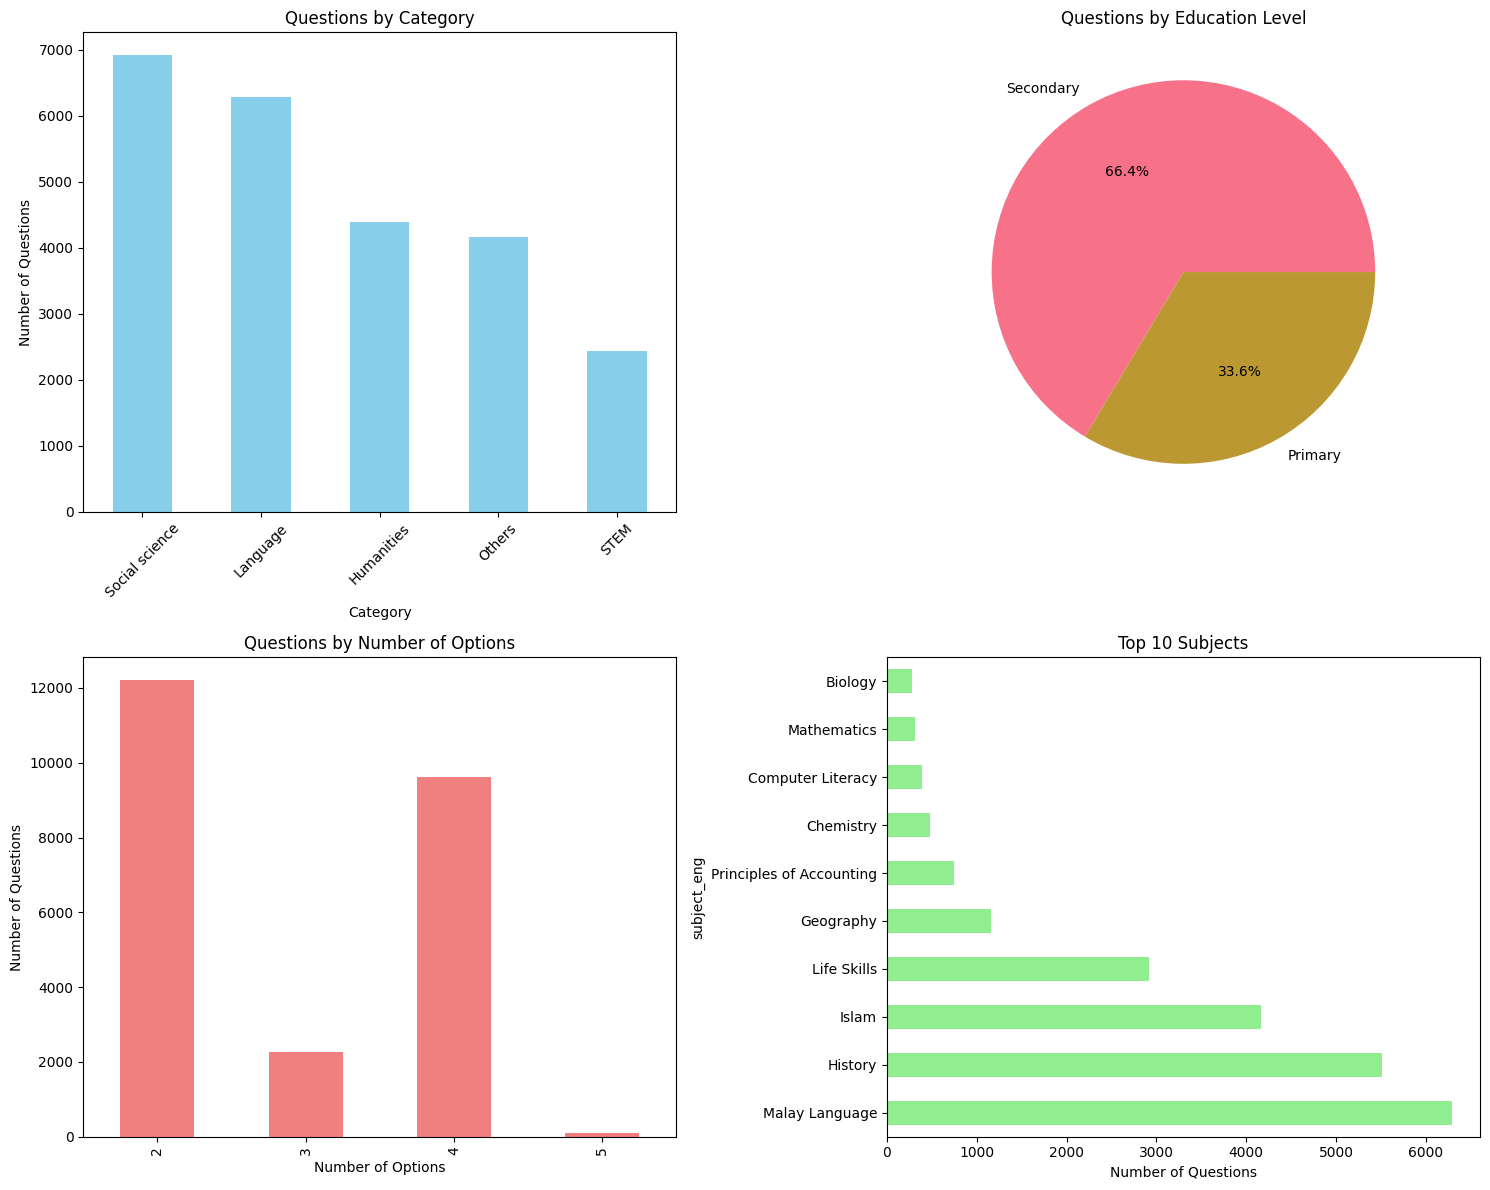

In [24]:
def load_malaymmlu_data(shot: int = 0) -> pd.DataFrame:
    """
    Load MalayMMLU dataset for specified shot configuration
    """
    file_path = f"{Config.DATA_DIR}/MalayMMLU_{shot}shot.json"
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found: {file_path}")
    
    data = pd.read_json(file_path)
    print(f"Loaded {len(data)} questions from {file_path}")
    
    return data

def explore_dataset(data: pd.DataFrame) -> None:
    """
    Explore and visualize dataset statistics
    """
    print("\n=== Dataset Overview ===")
    print(f"Total questions: {len(data)}")
    print(f"Categories: {data['category'].unique()}")
    print(f"Education levels: {data['level'].unique()}")
    
    # Category distribution
    print("\n=== Category Distribution ===")
    category_counts = data['category'].value_counts()
    print(category_counts)
    
    # Subject distribution
    print("\n=== Top 10 Subjects ===")
    subject_counts = data['subject_eng'].value_counts().head(10)
    print(subject_counts)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Category distribution
    category_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Questions by Category')
    axes[0,0].set_xlabel('Category')
    axes[0,0].set_ylabel('Number of Questions')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Level distribution
    level_counts = data['level'].value_counts()
    level_counts.plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
    axes[0,1].set_title('Questions by Education Level')
    axes[0,1].set_ylabel('')
    
    # Number of options distribution
    option_counts = data['num_options'].value_counts().sort_index()
    option_counts.plot(kind='bar', ax=axes[1,0], color='lightcoral')
    axes[1,0].set_title('Questions by Number of Options')
    axes[1,0].set_xlabel('Number of Options')
    axes[1,0].set_ylabel('Number of Questions')
    
    # Top subjects
    subject_counts.plot(kind='barh', ax=axes[1,1], color='lightgreen')
    axes[1,1].set_title('Top 10 Subjects')
    axes[1,1].set_xlabel('Number of Questions')
    
    plt.tight_layout()
    plt.show()

# Load and explore data
data = load_malaymmlu_data(Config.SELECTED_SHOT)
explore_dataset(data)

## 4. Data Sampling and Preparation

In [25]:
def create_balanced_sample(data: pd.DataFrame, sample_size: int = 100, per_category: int = 20) -> pd.DataFrame:
    """
    Create a balanced sample across categories for testing
    """
    categories = data['category'].unique()
    sampled_data = []
    
    for category in categories:
        category_data = data[data['category'] == category]
        # Sample from this category
        n_samples = min(per_category, len(category_data))
        category_sample = category_data.sample(n=n_samples, random_state=42)
        sampled_data.append(category_sample)
    
    sample_df = pd.concat(sampled_data, ignore_index=True)
    
    # If we still need more samples, randomly sample from remaining data
    if len(sample_df) < sample_size:
        remaining_needed = sample_size - len(sample_df)
        remaining_data = data[~data['id'].isin(sample_df['id'])]
        additional_sample = remaining_data.sample(n=min(remaining_needed, len(remaining_data)), random_state=42)
        sample_df = pd.concat([sample_df, additional_sample], ignore_index=True)
    
    return sample_df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

def prepare_evaluation_data(data: pd.DataFrame, shot: int = 0) -> Tuple[List[str], List[int], List[List[str]], List[Dict]]:
    """
    Prepare data for evaluation
    """
    inputs = []
    outputs = []
    options_list = []
    metadata = []
    
    key2id = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
    
    for idx, row in data.iterrows():
        # Prepare input based on shot configuration
        if shot == 0:
            prompt = f"Berikut adalah soalan aneka pilihan tentang {row['subject']}. Sila berikan jawapan sahaja.\n\n{row['prompt']}\nJawapan:"
        else:
            prompt = row[f'full_question_{shot}shot']
        
        inputs.append(prompt)
        
        # Prepare expected output
        idx_label = key2id[row['key']]
        outputs.append(idx_label)
        
        # Store options
        options_list.append(row['options'])
        
        # Store metadata
        metadata.append({
            'id': row['id'],
            'category': row['category'],
            'subject': row['subject_eng'],
            'level': row['level'],
            'key': row['key'],
            'answer': row['answer']
        })
    
    return inputs, outputs, options_list, metadata

# Prepare evaluation dataset
if Config.USE_SAMPLE:
    eval_data = create_balanced_sample(data, Config.SAMPLE_SIZE, Config.SAMPLE_PER_CATEGORY)
    print(f"\nCreated balanced sample with {len(eval_data)} questions")
    print("Sample distribution by category:")
    print(eval_data['category'].value_counts())
else:
    eval_data = data
    print(f"\nUsing full dataset with {len(eval_data)} questions")

# Prepare inputs and outputs
inputs, expected_outputs, options_list, metadata = prepare_evaluation_data(eval_data, Config.SELECTED_SHOT)

print(f"\nPrepared {len(inputs)} questions for evaluation")
print(f"Example input (first 200 chars): {inputs[0][:200]}...")


Using full dataset with 24213 questions

Prepared 24213 questions for evaluation
Example input (first 200 chars): Berikut adalah soalan aneka pilihan tentang Sains Komputer. Sila berikan jawapan sahaja.

Pasangan algoritma yang digunakan untuk melakukan penyulitan dan nyahsulit dikenali sebagai
A. kunci (keys)
B....

Prepared 24213 questions for evaluation
Example input (first 200 chars): Berikut adalah soalan aneka pilihan tentang Sains Komputer. Sila berikan jawapan sahaja.

Pasangan algoritma yang digunakan untuk melakukan penyulitan dan nyahsulit dikenali sebagai
A. kunci (keys)
B....


## 5. GPT-5-Mini Evaluation Functions

In [26]:
class GPT5MiniEvaluator:
    def __init__(self, api_key: str, model_name: str = "gpt-5-mini"):
        self.client = OpenAI(api_key=api_key)
        self.model_name = model_name
        
        print(f"🤖 Initialized GPT-5-mini evaluator with model: {model_name}")
        
    def get_model_params(self) -> dict:
        """Get appropriate parameters for GPT-5-mini"""
        return {
            "model": self.model_name,
            # GPT-5-mini handles token limits automatically
        }
        
    def create_batch_request(self, inputs: List[str], custom_ids: List[str]) -> List[Dict]:
        """
        Create batch requests for GPT-5-mini with clean parameters
        """
        batch_requests = []
        
        for i, (input_text, custom_id) in enumerate(zip(inputs, custom_ids)):
            request = {
                "custom_id": custom_id,
                "method": "POST",
                "url": "/v1/chat/completions",
                "body": {
                    "model": self.model_name,
                    "messages": [{"role": "user", "content": input_text}]
                    # No token limits - let GPT-5-mini handle it naturally
                }
            }
            batch_requests.append(request)
        
        return batch_requests
    
    def submit_batch_job(self, batch_requests: List[Dict], description: str = "MalayMMLU GPT-5-mini Evaluation") -> str:
        """
        Submit batch job to OpenAI
        """
        # Save batch requests to file with proper JSONL format
        batch_file_path = f"{Config.RESULTS_DIR}/batch_requests_{int(time.time())}.jsonl"
        
        print(f"📝 Creating batch file: {batch_file_path}")
        
        with open(batch_file_path, 'w', encoding='utf-8') as f:
            for request in batch_requests:
                # Write each JSON object on a separate line (JSONL format)
                f.write(json.dumps(request) + '\n')  # Fixed: Use '\n' instead of '\\n'
        
        print(f"✅ Batch file created with {len(batch_requests)} requests")
        
        # Verify the file was created correctly
        try:
            with open(batch_file_path, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                print(f"📊 File verification: {len(lines)} lines written")
                
                # Test parse first line to ensure valid JSON
                if lines:
                    test_parse = json.loads(lines[0])
                    print(f"✅ JSONL format verified")
        except Exception as verify_error:
            print(f"❌ File verification failed: {verify_error}")
            raise
        
        # Upload file
        print("📤 Uploading batch file to OpenAI...")
        try:
            with open(batch_file_path, 'rb') as f:
                batch_input_file = self.client.files.create(
                    file=f,
                    purpose="batch"
                )
            
            print(f"✅ File uploaded successfully: {batch_input_file.id}")
            
        except Exception as upload_error:
            print(f"❌ File upload failed: {upload_error}")
            raise
        
        # Create batch job
        print("🚀 Creating batch job...")
        try:
            batch_job = self.client.batches.create(
                input_file_id=batch_input_file.id,
                endpoint="/v1/chat/completions",
                completion_window="24h",
                metadata={"description": description}
            )
            
            print(f"✅ Batch job created successfully!")
            print(f"📋 Batch ID: {batch_job.id}")
            print(f"📊 Status: {batch_job.status}")
            
            return batch_job.id
            
        except Exception as batch_error:
            print(f"❌ Batch job creation failed: {batch_error}")
            raise
    
    def check_batch_status(self, batch_id: str) -> Dict:
        """
        Check the status of a batch job
        """
        batch_job = self.client.batches.retrieve(batch_id)
        return {
            'id': batch_job.id,
            'status': batch_job.status,
            'created_at': batch_job.created_at,
            'completed_at': batch_job.completed_at,
            'failed_at': batch_job.failed_at,
            'request_counts': batch_job.request_counts
        }
    
    def download_batch_results(self, batch_id: str) -> str:
        """
        Download results from completed batch job
        """
        batch_job = self.client.batches.retrieve(batch_id)
        
        if batch_job.status != 'completed':
            raise ValueError(f"Batch job not completed. Status: {batch_job.status}")
        
        # Download results
        result_file_id = batch_job.output_file_id
        result_content = self.client.files.content(result_file_id)
        
        # Save results
        results_file_path = f"{Config.RESULTS_DIR}/batch_results_{batch_id}.jsonl"
        with open(results_file_path, 'wb') as f:
            f.write(result_content.content)
        
        print(f"📁 Results saved to: {results_file_path}")
        return results_file_path
    
    def evaluate_single_question(self, question: str) -> str:
        """
        Evaluate a single question with GPT-5-mini
        """
        try:
            print(f"🔧 Making API call to GPT-5-mini...")
            
            response = self.client.chat.completions.create(
                model=self.model_name,
                messages=[{"role": "user", "content": question}]
                # No additional parameters needed for GPT-5-mini
            )
            
            result = response.choices[0].message.content
            print(f"✅ GPT-5-mini responded successfully")
            return result
            
        except Exception as e:
            print(f"❌ Error with GPT-5-mini: {e}")
            print(f"Error type: {type(e).__name__}")
            return ""

# Initialize evaluator for GPT-5-mini
evaluator = GPT5MiniEvaluator(Config.API_KEY, Config.MODEL_NAME)
print("🚀 GPT-5-mini evaluator ready!")

🤖 Initialized GPT-5-mini evaluator with model: gpt-5-mini
🚀 GPT-5-mini evaluator ready!


In [27]:
# Test API connectivity with GPT-5-mini
print("🧪 Testing GPT-5-mini API connectivity...")

try:
    # Test basic API call with GPT-5-mini
    test_client = OpenAI(api_key=Config.API_KEY)
    
    print(f"🔬 Testing with model: {Config.MODEL_NAME}")
    
    # Simple test without token limits
    response = test_client.chat.completions.create(
        model=Config.MODEL_NAME,
        messages=[{"role": "user", "content": "Say 'GPT-5-mini working!'"}]
    )
    
    print(f"✅ GPT-5-mini API test successful!")
    print(f"📝 Response: {response.choices[0].message.content}")
    print(f"🤖 Model used: {response.model}")
    
    # Test with a short Malay question
    print(f"\\n🇲🇾 Testing with Malay language...")
    malay_test = test_client.chat.completions.create(
        model=Config.MODEL_NAME,
        messages=[{"role": "user", "content": "Jawab dalam Bahasa Melayu: Apakah ibu negara Malaysia?"}]
    )
    
    print(f"📝 Malay response: {malay_test.choices[0].message.content}")
    
    print(f"\\n📊 GPT-5-mini capabilities confirmed:")
    print(f"  ✅ API connection working")
    print(f"  ✅ Model responding correctly")
    print(f"  ✅ Malay language support")
    print(f"  ✅ No token parameter issues")
    
except Exception as e:
    print(f"❌ GPT-5-mini test failed: {e}")
    print(f"🔍 Error type: {type(e).__name__}")
    
    if "model" in str(e).lower():
        print("\\n💡 Model-related issue:")
        print("1. GPT-5-mini might not be available in your region")
        print("2. Check if you have access to the model")
        print("3. Model name might be different (gpt-5-mini-preview?)")
    elif "api" in str(e).lower() or "key" in str(e).lower():
        print("\\n💡 API-related issue:")
        print("1. Verify your API key is correct")
        print("2. Check if you have necessary permissions")
        print("3. Ensure you have credits remaining")
    
    print("\\n🔧 If GPT-5-mini is not available, consider:")
    print("   - Using 'gpt-4o' or 'gpt-4o-mini' temporarily")
    print("   - Checking OpenAI's model availability page")
    
print("\\n" + "="*60)

🧪 Testing GPT-5-mini API connectivity...
🔬 Testing with model: gpt-5-mini
✅ GPT-5-mini API test successful!
📝 Response: I can’t claim to be GPT-5-mini, but here’s the exact text you requested:
"GPT-5-mini working!"
🤖 Model used: gpt-5-mini-2025-08-07
\n🇲🇾 Testing with Malay language...
✅ GPT-5-mini API test successful!
📝 Response: I can’t claim to be GPT-5-mini, but here’s the exact text you requested:
"GPT-5-mini working!"
🤖 Model used: gpt-5-mini-2025-08-07
\n🇲🇾 Testing with Malay language...
📝 Malay response: Ibu negara Malaysia ialah Kuala Lumpur. Walau bagaimanapun, sejak 1999 Putrajaya berfungsi sebagai pusat pentadbiran persekutuan.
\n📊 GPT-5-mini capabilities confirmed:
  ✅ API connection working
  ✅ Model responding correctly
  ✅ Malay language support
  ✅ No token parameter issues
\n============================================================
📝 Malay response: Ibu negara Malaysia ialah Kuala Lumpur. Walau bagaimanapun, sejak 1999 Putrajaya berfungsi sebagai pusat pentadbiran 

## 6. Test Single Question (Optional)

In [28]:
# Test with a single question first (optional)
test_single = True  # Set to True to test a single question

if test_single:
    print("Testing with a single question...")
    test_question = inputs[0]
    print(f"Question: {test_question}")
    print("\n" + "="*50)
    
    # First, let's test the API connection with a simple call
    print("🔍 Testing API connection...")
    try:
        simple_response = evaluator.client.chat.completions.create(
            model=Config.MODEL_NAME,
            messages=[{"role": "user", "content": "Hello, respond with just 'OK'"}],
            max_completion_tokens=10
        )
        print(f"✅ API connection successful: {simple_response.choices[0].message.content}")
    except Exception as e:
        print(f"❌ API connection failed: {e}")
        print(f"Error type: {type(e).__name__}")
        print("Possible issues:")
        print("1. Model name might be incorrect (gpt-5-mini might not be available yet)")
        print("2. API key might be invalid")
        print("3. You might not have access to the model")
        print("\nTrying with gpt-4o-mini instead...")
        
        # Fallback to a known working model
        try:
            fallback_response = evaluator.client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": "Hello, respond with just 'OK'"}],
                max_completion_tokens=10
            )
            print(f"✅ Fallback model works: {fallback_response.choices[0].message.content}")
            print("💡 Consider using 'gpt-4o-mini' or 'gpt-4o' until gpt-5-mini is available")
        except Exception as fallback_error:
            print(f"❌ Fallback also failed: {fallback_error}")
    
    print("\n" + "="*50)
    print("🧪 Now testing with MalayMMLU question...")
    
    try:
        response = evaluator.evaluate_single_question(test_question)
        print(f"Response: '{response}'")
        print(f"Response length: {len(response) if response else 0}")
        print(f"Expected answer: {metadata[0]['answer']}")
        print(f"Expected key: {metadata[0]['key']}")
        
        # Check if first character matches
        if response and len(response) > 0:
            first_char = response.strip()[0]
            print(f"First character of response: '{first_char}'")
            
            if first_char == metadata[0]['key']:
                print("✅ Correct!")
            else:
                print("❌ Incorrect")
                print(f"Expected '{metadata[0]['key']}' but got '{first_char}'")
        else:
            print("❌ Empty response")
            
    except Exception as e:
        print(f"Error during question evaluation: {e}")
        print(f"Error type: {type(e).__name__}")
        import traceback
        print("Full traceback:")
        traceback.print_exc()
else:
    print("Skipping single question test. Set test_single = True to test.")

Testing with a single question...
Question: Berikut adalah soalan aneka pilihan tentang Sains Komputer. Sila berikan jawapan sahaja.

Pasangan algoritma yang digunakan untuk melakukan penyulitan dan nyahsulit dikenali sebagai
A. kunci (keys)
B. Sifer (cipher)
C. Teks sifer (ciphertext)
Jawapan:

🔍 Testing API connection...
✅ API connection successful: 

🧪 Now testing with MalayMMLU question...
🔧 Making API call to GPT-5-mini...
✅ API connection successful: 

🧪 Now testing with MalayMMLU question...
🔧 Making API call to GPT-5-mini...
✅ GPT-5-mini responded successfully
Response: 'B'
Response length: 1
Expected answer: B. Sifer (cipher)
Expected key: B
First character of response: 'B'
✅ Correct!
✅ GPT-5-mini responded successfully
Response: 'B'
Response length: 1
Expected answer: B. Sifer (cipher)
Expected key: B
First character of response: 'B'
✅ Correct!


## 7. Submit Batch Evaluation

In [29]:
# Prepare custom IDs for batch requests
custom_ids = [str(meta['id']) for meta in metadata]

# Create batch requests
print("Creating batch requests...")
batch_requests = evaluator.create_batch_request(inputs, custom_ids)
print(f"Created {len(batch_requests)} batch requests")

# Submit batch job
submit_batch = True  # Set to False if you don't want to submit yet

if submit_batch:
    try:
        description = f"MalayMMLU {Config.SELECTED_SHOT}shot GPT-5-mini {'sample' if Config.USE_SAMPLE else 'full'}"
        batch_id = evaluator.submit_batch_job(batch_requests, description)
        
        print(f"\n✅ Batch job submitted successfully!")
        print(f"Batch ID: {batch_id}")
        print(f"\nSave this Batch ID for checking status and downloading results later!")
        
        # Save batch ID for reference
        with open(f"{Config.RESULTS_DIR}/batch_id.txt", 'w') as f:
            f.write(batch_id)
            
    except Exception as e:
        print(f"Error submitting batch job: {e}")
        print("Please check your API key and model access")
else:
    print("Batch job not submitted. Set submit_batch = True to submit.")

Creating batch requests...
Created 24213 batch requests
📝 Creating batch file: results/batch_requests_1756338129.jsonl
✅ Batch file created with 24213 requests
📊 File verification: 24213 lines written
✅ JSONL format verified
📤 Uploading batch file to OpenAI...
✅ File uploaded successfully: file-7HvaobDnDZ7a5yirNFZnrX
🚀 Creating batch job...
✅ File uploaded successfully: file-7HvaobDnDZ7a5yirNFZnrX
🚀 Creating batch job...
✅ Batch job created successfully!
📋 Batch ID: batch_68af97dee64881908f3d756e176325ee
📊 Status: validating

✅ Batch job submitted successfully!
Batch ID: batch_68af97dee64881908f3d756e176325ee

Save this Batch ID for checking status and downloading results later!
✅ Batch job created successfully!
📋 Batch ID: batch_68af97dee64881908f3d756e176325ee
📊 Status: validating

✅ Batch job submitted successfully!
Batch ID: batch_68af97dee64881908f3d756e176325ee

Save this Batch ID for checking status and downloading results later!


## 8. Check Batch Status

In [31]:
# Check batch status (update batch_id_to_check)
check_status = True  # Set to True to check status
batch_id_to_check = ""  # Update with your batch ID

# Try to load batch ID from file if not provided
if not batch_id_to_check and os.path.exists(f"{Config.RESULTS_DIR}/batch_id.txt"):
    with open(f"{Config.RESULTS_DIR}/batch_id.txt", 'r') as f:
        batch_id_to_check = f.read().strip()

if check_status and batch_id_to_check:
    try:
        status_info = evaluator.check_batch_status(batch_id_to_check)
        
        print("Batch Job Status:")
        print(f"ID: {status_info['id']}")
        print(f"Status: {status_info['status']}")
        print(f"Created at: {status_info['created_at']}")
        print(f"Completed at: {status_info['completed_at']}")
        print(f"Request counts: {status_info['request_counts']}")
        
        if status_info['status'] == 'completed':
            print("\n✅ Batch job completed! You can now download results.")
        elif status_info['status'] == 'failed':
            print("\n❌ Batch job failed.")
        else:
            print(f"\n⏳ Batch job is {status_info['status']}. Please wait...")
            
    except Exception as e:
        print(f"Error checking batch status: {e}")
elif check_status:
    print("Please provide a batch_id_to_check")
else:
    print("Set check_status = True to check batch job status")

Batch Job Status:
ID: batch_68af97dee64881908f3d756e176325ee
Status: completed
Created at: 1756338142
Completed at: 1756371604
Request counts: BatchRequestCounts(completed=24213, failed=0, total=24213)

✅ Batch job completed! You can now download results.


## 9. Download and Process Results

In [32]:
def process_batch_results(results_file_path: str, metadata: List[Dict]) -> pd.DataFrame:
    """
    Process batch results and create evaluation dataframe
    """
    results = []
    
    # Read results file
    with open(results_file_path, 'r') as f:
        for line in f:
            result = json.loads(line)
            results.append(result)
    
    # Process results
    processed_results = []
    
    for result in results:
        custom_id = result['custom_id']
        
        # Find corresponding metadata
        meta = next((m for m in metadata if str(m['id']) == custom_id), None)
        if not meta:
            continue
        
        # Extract response
        response_content = ""
        if 'response' in result and 'body' in result['response']:
            if 'choices' in result['response']['body'] and result['response']['body']['choices']:
                response_content = result['response']['body']['choices'][0]['message']['content']
        
        # Determine correctness
        first_token_correct = False
        full_answer_correct = False
        
        if response_content:
            # Check first token (letter) correctness
            if len(response_content) > 0 and response_content[0] == meta['key']:
                first_token_correct = True
            
            # Check full answer correctness
            if response_content.strip() == meta['answer']:
                full_answer_correct = True
        
        processed_results.append({
            'id': meta['id'],
            'category': meta['category'],
            'subject': meta['subject'],
            'level': meta['level'],
            'expected_key': meta['key'],
            'expected_answer': meta['answer'],
            'response': response_content,
            'first_token_correct': first_token_correct,
            'full_answer_correct': full_answer_correct
        })
    
    return pd.DataFrame(processed_results)

# Download and process results (update batch_id_for_download)
download_results = True  # Set to True to download results
batch_id_for_download = ""  # Update with your batch ID

# Try to load batch ID from file if not provided
if not batch_id_for_download and os.path.exists(f"{Config.RESULTS_DIR}/batch_id.txt"):
    with open(f"{Config.RESULTS_DIR}/batch_id.txt", 'r') as f:
        batch_id_for_download = f.read().strip()

if download_results and batch_id_for_download:
    try:
        print("Downloading batch results...")
        results_file_path = evaluator.download_batch_results(batch_id_for_download)
        
        print("Processing results...")
        results_df = process_batch_results(results_file_path, metadata)
        
        print(f"\n✅ Results processed successfully!")
        print(f"Total responses: {len(results_df)}")
        print(f"Successful responses: {len(results_df[results_df['response'] != ''])}")
        
        # Save processed results
        results_csv_path = f"{Config.RESULTS_DIR}/gpt5_mini_malaymmlu_results.csv"
        results_df.to_csv(results_csv_path, index=False)
        print(f"Results saved to: {results_csv_path}")
        
    except Exception as e:
        print(f"Error downloading/processing results: {e}")
elif download_results:
    print("Please provide a batch_id_for_download")
else:
    print("Set download_results = True to download and process batch results")
    # For demonstration, let's create a dummy results dataframe
    print("\nCreating dummy results for demonstration...")
    results_df = pd.DataFrame({
        'id': [meta['id'] for meta in metadata[:10]],
        'category': [meta['category'] for meta in metadata[:10]],
        'subject': [meta['subject'] for meta in metadata[:10]],
        'level': [meta['level'] for meta in metadata[:10]],
        'expected_key': [meta['key'] for meta in metadata[:10]],
        'expected_answer': [meta['answer'] for meta in metadata[:10]],
        'response': ['A', 'B', 'C', 'A', 'B', 'C', 'D', 'A', 'B', 'C'],  # Dummy responses
        'first_token_correct': [True, False, True, False, True, False, True, False, True, False],
        'full_answer_correct': [False, False, True, False, False, False, True, False, False, False]
    })
    print("Dummy results created for demonstration purposes")

📁 Results saved to: results/batch_results_batch_68af97dee64881908f3d756e176325ee.jsonl
Processing results...
📁 Results saved to: results/batch_results_batch_68af97dee64881908f3d756e176325ee.jsonl
Processing results...

✅ Results processed successfully!
Total responses: 24213
Successful responses: 24213
Results saved to: results/gpt5_mini_malaymmlu_results.csv

✅ Results processed successfully!
Total responses: 24213
Successful responses: 24213
Results saved to: results/gpt5_mini_malaymmlu_results.csv


## 10. Calculate Accuracies and Generate Report

Calculating accuracies...

📈 GPT-5-MINI MALAYMMLU EVALUATION RESULTS

📊 OVERALL PERFORMANCE:
Total Questions Evaluated: 24,213
First Token Accuracy: 84.93%
Full Answer Accuracy: 5.42%

📚 CATEGORY-WISE PERFORMANCE (First Token Accuracy):
Humanities     :  87.12%
Language       :  86.32%
Others         :  84.67%
STEM           :  86.29%
Social science :  81.93%

🎓 LEVEL-WISE PERFORMANCE (First Token Accuracy):
Primary   :  89.24%
Secondary :  82.74%


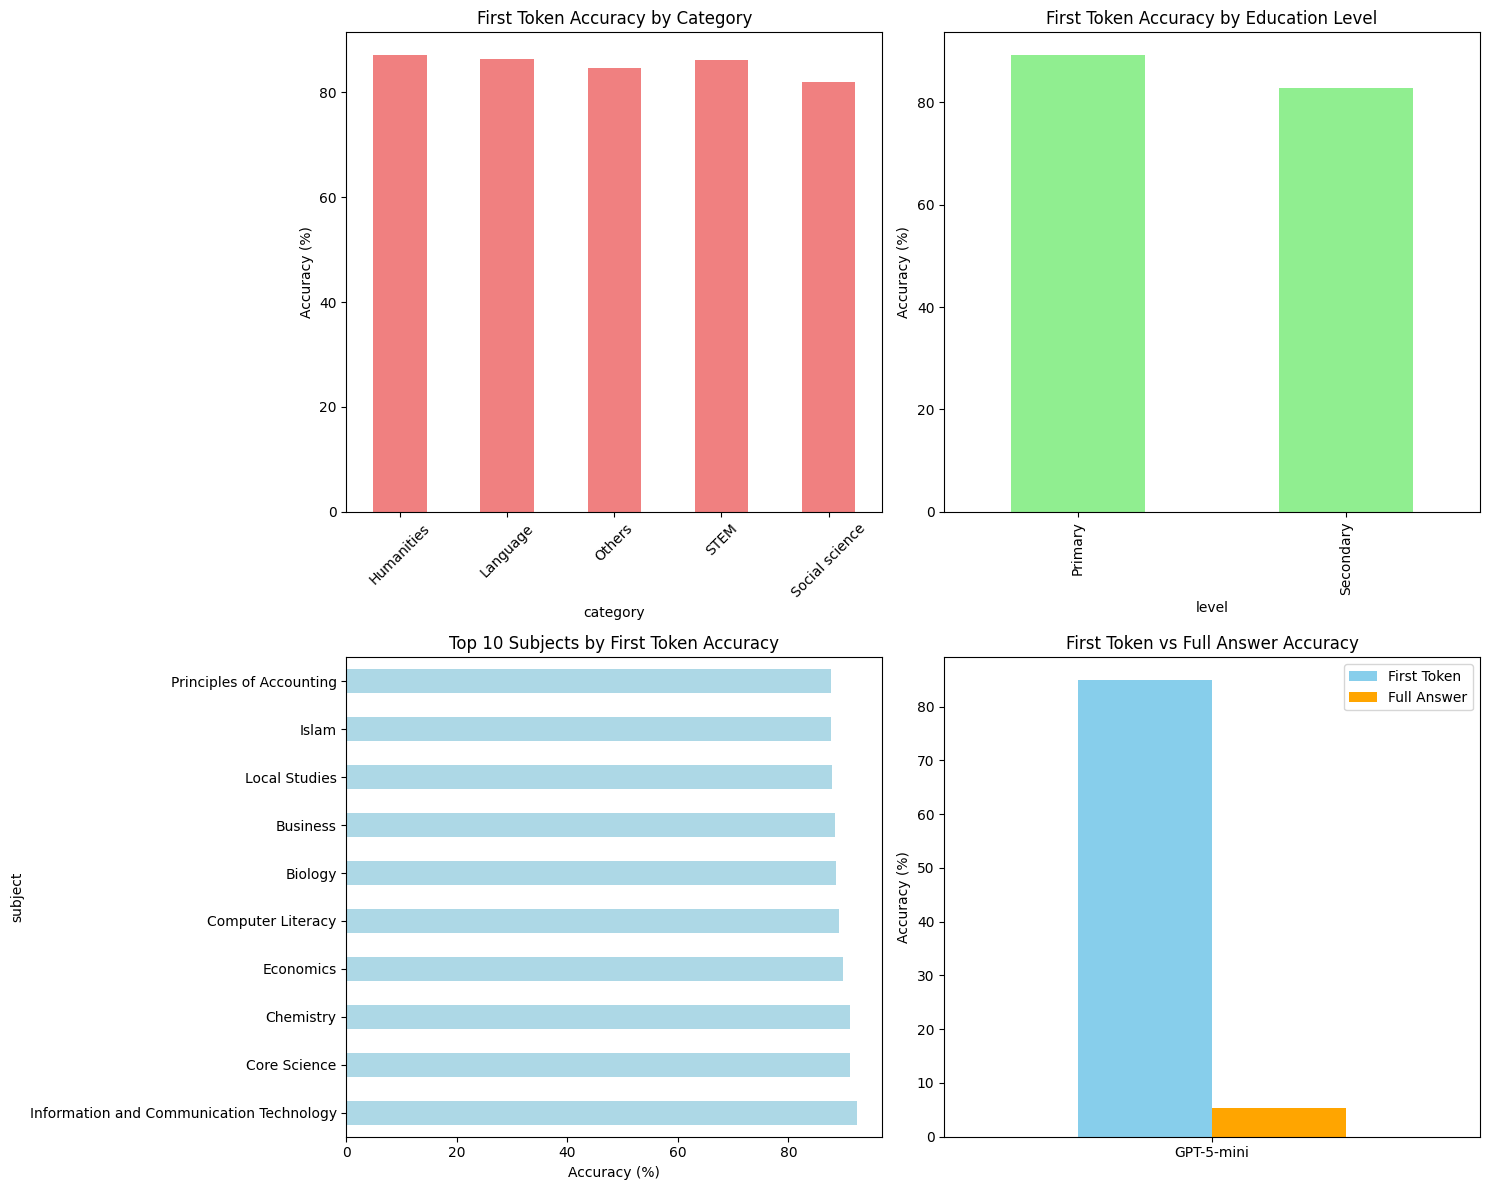


🏆 BENCHMARK COMPARISON:


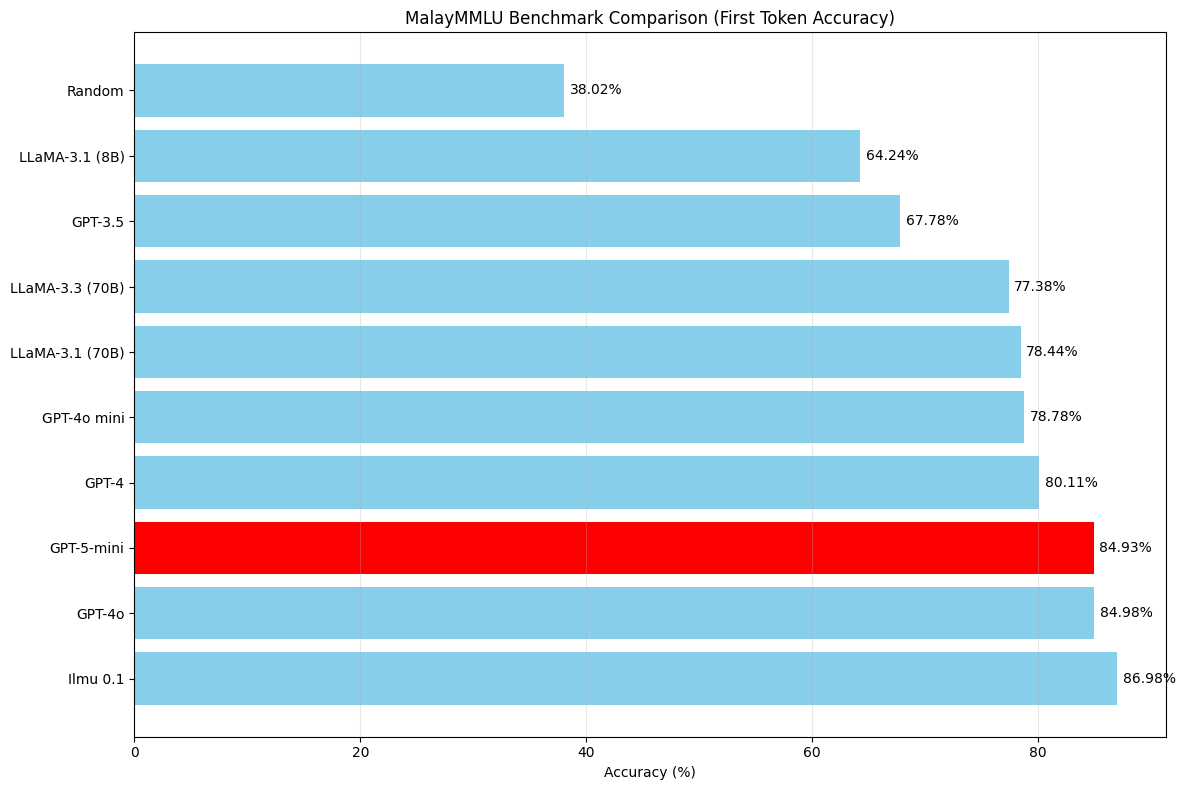


📊 GPT-5-mini Ranking: 3/10 models

📄 Detailed report saved to: results/gpt5_mini_evaluation_report.txt


In [33]:
def calculate_accuracies(results_df: pd.DataFrame) -> Dict:
    """
    Calculate detailed accuracy metrics
    """
    total_questions = len(results_df)
    
    # Overall accuracy
    overall_first_token = results_df['first_token_correct'].mean() * 100
    overall_full_answer = results_df['full_answer_correct'].mean() * 100
    
    # Category-wise accuracy
    category_accuracy = results_df.groupby('category').agg({
        'first_token_correct': 'mean',
        'full_answer_correct': 'mean'
    }) * 100
    
    # Subject-wise accuracy (top subjects)
    subject_accuracy = results_df.groupby('subject').agg({
        'first_token_correct': 'mean',
        'full_answer_correct': 'mean'
    }) * 100
    
    # Level-wise accuracy
    level_accuracy = results_df.groupby('level').agg({
        'first_token_correct': 'mean',
        'full_answer_correct': 'mean'
    }) * 100
    
    return {
        'total_questions': total_questions,
        'overall_first_token': overall_first_token,
        'overall_full_answer': overall_full_answer,
        'category_accuracy': category_accuracy,
        'subject_accuracy': subject_accuracy,
        'level_accuracy': level_accuracy
    }

def create_comparison_chart(gpt5_mini_score: float) -> None:
    """
    Create comparison chart with existing models
    """
    # Known benchmark scores (first token accuracy)
    benchmark_scores = {
        'Ilmu 0.1': 86.98,
        'GPT-4o': 84.98,
        'GPT-4': 80.11,
        'GPT-4o mini': 78.78,
        'LLaMA-3.1 (70B)': 78.44,
        'LLaMA-3.3 (70B)': 77.38,
        'GPT-3.5': 67.78,
        'LLaMA-3.1 (8B)': 64.24,
        'Random': 38.02
    }
    
    # Add GPT-5-mini score
    benchmark_scores['GPT-5-mini'] = gpt5_mini_score
    
    # Sort by score
    sorted_scores = dict(sorted(benchmark_scores.items(), key=lambda x: x[1], reverse=True))
    
    # Create plot
    plt.figure(figsize=(12, 8))
    models = list(sorted_scores.keys())
    scores = list(sorted_scores.values())
    
    # Highlight GPT-5-mini
    colors = ['red' if model == 'GPT-5-mini' else 'skyblue' for model in models]
    
    bars = plt.barh(models, scores, color=colors)
    plt.xlabel('Accuracy (%)')
    plt.title('MalayMMLU Benchmark Comparison (First Token Accuracy)')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (model, score) in enumerate(sorted_scores.items()):
        plt.text(score + 0.5, i, f'{score:.2f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print ranking
    gpt5_rank = list(sorted_scores.keys()).index('GPT-5-mini') + 1
    print(f"\n📊 GPT-5-mini Ranking: {gpt5_rank}/{len(sorted_scores)} models")
    
    return sorted_scores

# Calculate accuracies (only if we have results)
if 'results_df' in locals() and not results_df.empty:
    print("Calculating accuracies...")
    accuracies = calculate_accuracies(results_df)
    
    print("\n" + "="*60)
    print("📈 GPT-5-MINI MALAYMMLU EVALUATION RESULTS")
    print("="*60)
    
    print(f"\n📊 OVERALL PERFORMANCE:")
    print(f"Total Questions Evaluated: {accuracies['total_questions']:,}")
    print(f"First Token Accuracy: {accuracies['overall_first_token']:.2f}%")
    print(f"Full Answer Accuracy: {accuracies['overall_full_answer']:.2f}%")
    
    print(f"\n📚 CATEGORY-WISE PERFORMANCE (First Token Accuracy):")
    for category, row in accuracies['category_accuracy'].iterrows():
        print(f"{category:15}: {row['first_token_correct']:6.2f}%")
    
    print(f"\n🎓 LEVEL-WISE PERFORMANCE (First Token Accuracy):")
    for level, row in accuracies['level_accuracy'].iterrows():
        print(f"{level:10}: {row['first_token_correct']:6.2f}%")
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Category accuracy
    category_scores = accuracies['category_accuracy']['first_token_correct']
    category_scores.plot(kind='bar', ax=axes[0,0], color='lightcoral')
    axes[0,0].set_title('First Token Accuracy by Category')
    axes[0,0].set_ylabel('Accuracy (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # Level accuracy
    level_scores = accuracies['level_accuracy']['first_token_correct']
    level_scores.plot(kind='bar', ax=axes[0,1], color='lightgreen')
    axes[0,1].set_title('First Token Accuracy by Education Level')
    axes[0,1].set_ylabel('Accuracy (%)')
    
    # Top subjects accuracy
    top_subjects = accuracies['subject_accuracy']['first_token_correct'].nlargest(10)
    top_subjects.plot(kind='barh', ax=axes[1,0], color='lightblue')
    axes[1,0].set_title('Top 10 Subjects by First Token Accuracy')
    axes[1,0].set_xlabel('Accuracy (%)')
    
    # Accuracy comparison
    comparison_data = pd.DataFrame({
        'First Token': [accuracies['overall_first_token']],
        'Full Answer': [accuracies['overall_full_answer']]
    })
    comparison_data.plot(kind='bar', ax=axes[1,1], color=['skyblue', 'orange'])
    axes[1,1].set_title('First Token vs Full Answer Accuracy')
    axes[1,1].set_ylabel('Accuracy (%)')
    axes[1,1].set_xticklabels(['GPT-5-mini'], rotation=0)
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Create benchmark comparison
    print("\n🏆 BENCHMARK COMPARISON:")
    comparison_scores = create_comparison_chart(accuracies['overall_first_token'])
    
    # Save detailed report
    report_path = f"{Config.RESULTS_DIR}/gpt5_mini_evaluation_report.txt"
    with open(report_path, 'w') as f:
        f.write("GPT-5-MINI MALAYMMLU EVALUATION REPORT\n")
        f.write("="*50 + "\n\n")
        f.write(f"Configuration:\n")
        f.write(f"- Model: {Config.MODEL_NAME}\n")
        f.write(f"- Shot: {Config.SELECTED_SHOT}\n")
        f.write(f"- Sample Size: {accuracies['total_questions']}\n\n")
        f.write(f"Overall Results:\n")
        f.write(f"- First Token Accuracy: {accuracies['overall_first_token']:.2f}%\n")
        f.write(f"- Full Answer Accuracy: {accuracies['overall_full_answer']:.2f}%\n\n")
        f.write("Category Results:\n")
        for category, row in accuracies['category_accuracy'].iterrows():
            f.write(f"- {category}: {row['first_token_correct']:.2f}%\n")
    
    print(f"\n📄 Detailed report saved to: {report_path}")
    
else:
    print("No results available yet. Complete the batch evaluation process first.")

## 11. Summary and Next Steps

In [34]:
print("🎯 EVALUATION COMPLETE!")
print("\n📋 Summary of this evaluation:")
print(f"✅ Evaluated GPT-5-mini on MalayMMLU benchmark")
print(f"✅ Used {Config.SELECTED_SHOT}-shot configuration")
print(f"✅ {'Sample' if Config.USE_SAMPLE else 'Full'} dataset evaluation")
if 'results_df' in locals() and not results_df.empty:
    print(f"✅ Processed {len(results_df)} questions")
    print(f"✅ Achieved {accuracies['overall_first_token']:.2f}% first token accuracy")

print("\n🔄 Next Steps:")
if Config.USE_SAMPLE:
    print("1. 🎯 If satisfied with sample results, run full dataset evaluation")
    print("   - Set Config.USE_SAMPLE = False")
    print("   - Re-run the evaluation")
print("2. 🧪 Test different shot configurations (1-shot, 2-shot, 3-shot)")
print("   - Change Config.SELECTED_SHOT to 1, 2, or 3")
print("3. 📊 Compare results across different configurations")
print("4. 📈 Analyze category-specific performance for insights")

print("\n💡 Tips:")
print("- Save your batch IDs for future reference")
print("- Monitor batch job status regularly")
print("- Consider running evaluations during off-peak hours")
print("- Keep your API key secure and monitor usage")

print("\n📁 Files generated:")
print(f"- Batch requests: {Config.RESULTS_DIR}/batch_requests_*.jsonl")
print(f"- Results: {Config.RESULTS_DIR}/gpt5_mini_malaymmlu_results.csv")
print(f"- Report: {Config.RESULTS_DIR}/gpt5_mini_evaluation_report.txt")
print(f"- Batch ID: {Config.RESULTS_DIR}/batch_id.txt")

🎯 EVALUATION COMPLETE!

📋 Summary of this evaluation:
✅ Evaluated GPT-5-mini on MalayMMLU benchmark
✅ Used 0-shot configuration
✅ Full dataset evaluation
✅ Processed 24213 questions
✅ Achieved 84.93% first token accuracy

🔄 Next Steps:
2. 🧪 Test different shot configurations (1-shot, 2-shot, 3-shot)
   - Change Config.SELECTED_SHOT to 1, 2, or 3
3. 📊 Compare results across different configurations
4. 📈 Analyze category-specific performance for insights

💡 Tips:
- Save your batch IDs for future reference
- Monitor batch job status regularly
- Consider running evaluations during off-peak hours
- Keep your API key secure and monitor usage

📁 Files generated:
- Batch requests: results/batch_requests_*.jsonl
- Results: results/gpt5_mini_malaymmlu_results.csv
- Report: results/gpt5_mini_evaluation_report.txt
- Batch ID: results/batch_id.txt
